## Scripts for EEG task analysis

1. subject level analysis
2. group level analysis

In [1]:
import mne
import sys
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

# project PATH
dataset_name = 'tms_eeg'
project_path_str = '/scratch/'+dataset_name
project_path = Path(project_path_str)

sys.path.append(str(project_path))
data_path     = project_path / 'data'
eeg_data_path = data_path / 'tACS_set'
output_dir    = data_path / 'tACS_out'
#read clinical data

In [2]:
# report major software version
import statsmodels 
import nilearn
import sys
print('python version:', sys.version)
print('numpy version:', np.__version__)
print('statsmodels version:', statsmodels.__version__)
print('nilearn version:', nilearn.__version__)
print('MNE version:', mne.__version__)

python version: 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
numpy version: 1.26.4
statsmodels version: 0.14.4
nilearn version: 0.11.0
MNE version: 1.7.0


In [3]:
# import private libs
from private_lib.eeg_utils import get_dataset_df, preproc_eeg, epoching_by_events
# Example usage
dataset_df = get_dataset_df(eeg_data_path)
dataset_df = dataset_df.set_index('participant_id')
# Display the DataFrame
print('The current status of the dataset:')
display(dataset_df)

The current status of the dataset:


,rsEEG_file,taskEEG_file
participant_id,,
sub-woc2-001,None,/scratch/tms_eeg/data/tACS_set/sub-woc2-001/su...
sub-woc2-002,None,/scratch/tms_eeg/data/tACS_set/sub-woc2-002/su...
sub-woc2-373,/scratch/tms_eeg/data/tACS_set/sub-woc2-373/su...,/scratch/tms_eeg/data/tACS_set/sub-woc2-373/su...
sub-woc2-374,/scratch/tms_eeg/data/tACS_set/sub-woc2-374/su...,/scratch/tms_eeg/data/tACS_set/sub-woc2-374/su...
sub-woc9-001,None,/scratch/tms_eeg/data/tACS_set/sub-woc9-001/su...
sub-woc9-002,None,/scratch/tms_eeg/data/tACS_set/sub-woc9-002/su...
sub-woc9-010,None,/scratch/tms_eeg/data/tACS_set/sub-woc9-010/su...
sub-woc9-011,/scratch/tms_eeg/data/tACS_set/sub-woc9-011/su...,/scratch/tms_eeg/data/tACS_set/sub-woc9-011/su...
sub-woc9-012,/scratch/tms_eeg/data/tACS_set/sub-woc9-012/su...,/scratch/tms_eeg/data/tACS_set/sub-woc9-012/su...


## Preprocessing

In [4]:
import mne
from private_lib.eeg_utils import epoching_by_events
# Specify the subject_id

subject_id = 'sub-woc9-023'

# proc parameters
#resample_freq = 200
PASS_band     = [0.5, 61]

T_min, T_max = -1, 2   # Time in seconds
# Baseline correction period (e.g., pre-stimulus period)
BASE_line = (-0.1, 0)  # Entire pre-stimulus period

# preproc
eeg_file_path = dataset_df.loc[subject_id, 'taskEEG_file']

subj_eeg = preproc_eeg(eeg_file_path, pass_band = PASS_band, random_STAT = 24, elp_file = data_path / 'standard-10-5-cap385_dehead.elp')

# event dict
events_dict = {
              # Visual stim related
              '8'  : 'vstim_on_after_correct',
              '9'  : 'vstim_on_after_no_response',
              '11' : 'vstim_on_after_wrong',
              # response related
              '88' : 'wrong_response',
              '90' : 'no_response',
              '99' : 'correct_response',
              # feedback related
              '4'  : 'feedback_on_after_correct',
              '5'  : 'feedback_on_after_no_response',
              '7'  : 'feedback_on_after_wrong',
              # Electic stim related
              '66' : 'estim_on_after_correct',
              '67' : 'estim_on_after_no_response',
              '68' : 'estim_on_after_wrong'
              }
# for subject 'sub-woc9-010' only
#events_dict = {
#              # Visual stim related
#              '0008'  : 'vstim_on_after_correct',
#              '0009'  : 'vstim_on_after_no_response',
#              '0011' : 'vstim_on_after_wrong',
#              # response related
#              '0088' : 'wrong_response',
#              '0090' : 'no_response',
#              '0099' : 'correct_response',
#              # feedback related
#              '0004'  : 'feedback_on_after_correct',
#              '0005'  : 'feedback_on_after_no_response',
#              '0007'  : 'feedback_on_after_wrong',
#              # Electic stim related
#              '0066' : 'estim_on_after_correct',
#              '0067' : 'estim_on_after_no_response',
#              '0068' : 'estim_on_after_wrong'
#              }

##
# 刺激marker实际只打了11，但是出现了8和9；反馈marker实际打了7，但出现了4，5。根据实验任务现场对照得出8，9，4，5的意思分别是表格中对应的意思。
# Define the time window (e.g., -200 ms to 800 ms)

# epoching by events
epochs, event_id_str = epoching_by_events(subj_eeg, events_dict, tmin=T_min, tmax = T_max, baseline = BASE_line)
print(epochs)
# average epochs
evoked_dict = {label: epochs[label].average() for label in event_id_str.keys()}


Reading /scratch/tms_eeg/data/tACS_set/sub-woc9-023/sub-woc9-023_ses-0_file-2_eeg.fdt


/scratch/tms_eeg/private_lib/eeg_utils.py:55: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(eeg_file_path, preload=True)


Reading 0 ... 924746  =      0.000 ...   924.746 secs...
<RawEEGLAB | sub-woc9-023_ses-0_file-2_eeg.fdt, 64 x 924747 (924.7 s), ~451.6 MB, data loaded>
Channel names: 64 ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
Sampling frequency: 1000.0 Hz
Recording duration: 924.75 seconds
Annotations (events): <Annotations | 482 segments: 0, Impedance (2), 11 (57), 4 (78), 67 (62), ...>
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 61.00 Hz
- Upper transition bandwidth: 15.25 Hz (-6 dB cutoff frequency: 68.62 Hz)
- Filter length: 217 samples (0.217 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 50 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.25 Hz
- Upper transition bandwidth: 0.25 Hz
- Filter length: 13201 samples (13.201 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Using EOG channel: EOG
EOG channel index for this subject is: [31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 467 significant peaks
Number of EOG events detected: 467
Detected 467 EOG artifacts
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 12.3s.
Using EOG channel: EOG
... filtering I

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EOG-related components: [0]
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 63 PCA components
Used Annotations descriptions: ['0, Impedance', '11', '4', '67', '68', '7', '8', '88', '99']
Filtered events dictionary: {'11': 'vstim_on_after_wrong', '4': 'feedback_on_after_correct', '67': 'estim_on_after_no_response', '68': 'estim_on_after_wrong', '7': 'feedback_on_after_wrong', '8': 'vstim_on_after_correct', '88': 'wrong_response', '99': 'correct_response'}
Event ID mapping: {'vstim_on_after_wrong': 11, 'feedback_on_after_correct': 4, 'estim_on_after_no_response': 67, 'estim_on_after_wrong': 68, 'feedback_on_after_wrong': 7, 'vstim_on_after_correct': 8, 'wrong_response': 88, 'correct_response': 99}
Mapped event IDs: {'vstim_on_after_wrong': 2, 'feedback_on_after_correct': 3, 'estim_on_after_no_response': 4, 'estim_on_after_wrong': 5, 'feedback_on_after_wrong': 6, 'vstim_on_after_correct': 7, 'wrong_respon

## Computing spectrum

In [5]:
## select condition and 
def get_freq_peak(evoked_dict, chan_name='Fz', freqs = np.arange(1, 40, 0.5), event_1='correct_response', event_2='wrong_response', spectrum_method='morlet', njobs_=8):
    chan_index = evoked_dict['correct_response'].ch_names.index(chan_name)
    print('Channel name:', chan_name, ', index :', chan_index)
    condition_1 = evoked_dict[event_1] 
    condition_2 = evoked_dict[event_2]
    if spectrum_method == 'morlet':
        from mne.time_frequency import tfr_morlet
        # following the parameters of the paper
        #freqs = np.arange(1, 40, 0.5)  # Frequencies from 1 to 40 Hz
        n_cycles = freqs / 7           # Number of cycles per frequency
        power_1 = tfr_morlet(condition_1, freqs=freqs, n_cycles=n_cycles, return_itc=False, n_jobs=njobs_)
        power_2 = tfr_morlet(condition_2, freqs=freqs, n_cycles=n_cycles, return_itc=False, n_jobs=njobs_)
    else:
        # use multitapper as default
        from mne.time_frequency import tfr_multitaper
        N_cycles = freqs / 2         # Number of cycles per frequency
        Time_Bandwidth = 4.0         # Time-bandwidth product (controls smoothing)
        # Define parameters for multitaper
        power_1 = tfr_multitaper(condition_1, freqs=freqs, time_bandwidth=Time_Bandwidth, n_cycles=N_cycles, return_itc=False, n_jobs=njobs_)
        power_2 = tfr_multitaper(condition_2, freqs=freqs, time_bandwidth=Time_Bandwidth, n_cycles=N_cycles, return_itc=False, n_jobs=njobs_)
    return power_1, power_2

def report_peak(power_1, power_2, time_range, freq_range, chan_name='Fz'):
    # Define the time and frequency ranges of interest
    #time_range = (0.2, 0.5)  # 200–500 ms (in seconds)
    #freq_range = (20, 45)    # 20–35 Hz
    # Find the indices for the specified time range
    time_mask = (power_1.times >= time_range[0]) & (power_1.times <= time_range[1])
    # Find the indices for the specified frequency range
    freq_mask = (power_1.freqs >= freq_range[0]) & (power_1.freqs <= freq_range[1])
    # Extract power for Fz
    chan_index = epochs.ch_names.index(chan_name)
    # Extract power data for the specified time and frequency ranges
    power_event1 = power_1.data[chan_index][:, time_mask]  # Shape: (n_freqs, n_times)
    power_event2 = power_2.data[chan_index][:, time_mask]
    # Focus only on the specified frequency range
    power_event1 = power_event1[freq_mask, :]
    power_event2 = power_event2[freq_mask, :]
    # Compute the mean power difference within the time and frequency ranges
    mean_diff = (power_event1 - power_event2).mean()
    print("Mean power difference between events",freq_range,f": {mean_diff}")
    # Compute mean power difference for each frequency within the time range
    freq_diffs = (power_event1 - power_event2).mean(axis=1)  # Mean across the time dimension
    # Identify the frequency with the largest difference
    max_diff_idx = np.argmax(np.abs(freq_diffs))
    max_diff_freq = power_1.freqs[freq_mask][max_diff_idx]
    max_diff_value = freq_diffs[max_diff_idx]
    print(f"Frequency with the largest difference: {max_diff_freq} Hz")
    print(f"Largest power difference: {max_diff_value}")
    return max_diff_freq, max_diff_idx, max_diff_value

## Get event related frequncy
Analysis focused on the:

Frequency : beta–gamma band frequencies (20–35 Hz) 

Electrode : Fz 

Time window : 200–500 ms after feedback onset, (consistent with the spectral, spatial and temporal locus of the positive feedback beta–gamma effect).

Target modulation frequency : Within the beta–gamma band, the frequency with maximum difference in mean total power between reward and punishment trials. 

frequency-tuned modulation was applied with a resolution of 0.5 Hz, 

In [6]:
event_id_str

{'vstim_on_after_wrong': 11,
 'feedback_on_after_correct': 4,
 'estim_on_after_no_response': 67,
 'estim_on_after_wrong': 68,
 'feedback_on_after_wrong': 7,
 'vstim_on_after_correct': 8,
 'wrong_response': 88,
 'correct_response': 99}

In [7]:
pick_channel = 'Fz'

#contrast_event_1 = 'feedback_on_after_correct',
#contrast_event_2 = 'estim_on_after_wrong',

contrast_event_1 = 'correct_response'
contrast_event_2 = 'wrong_response'

# freq resolution
freq_max = 60
freq_min = 1
freq_step = 0.5

# search range
time_range = (0.2, 0.5)  # 200–500 ms (in seconds)
freq_range = (20, 45)    # 20–35 Hz

#
BASE_line = (-0.1, 0)  # Entire pre-stimulus period

#
power_1, power_2 = get_freq_peak(evoked_dict, chan_name=pick_channel, freqs = np.arange(freq_min, freq_max, freq_step), 
                                 event_1=contrast_event_1, event_2=contrast_event_2, 
                                 spectrum_method='multitapper', njobs_=8) #morlet, multitapper

Channel name: Fz , index : 5
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.8s


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`


[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    0.6s finished


## Report results here:

In [8]:
print(subject_id,':')
max_diff_freq_fz, max_diff_idx_fz, max_diff_value_fz = report_peak(power_1, power_2, time_range, freq_range, chan_name='Fz')

sub-woc9-023 :
Mean power difference between events (20, 45) : -8.928262417140387e-13
Frequency with the largest difference: 22.5 Hz
Largest power difference: -2.53491534068417e-12


Applying baseline correction (mode: logratio)


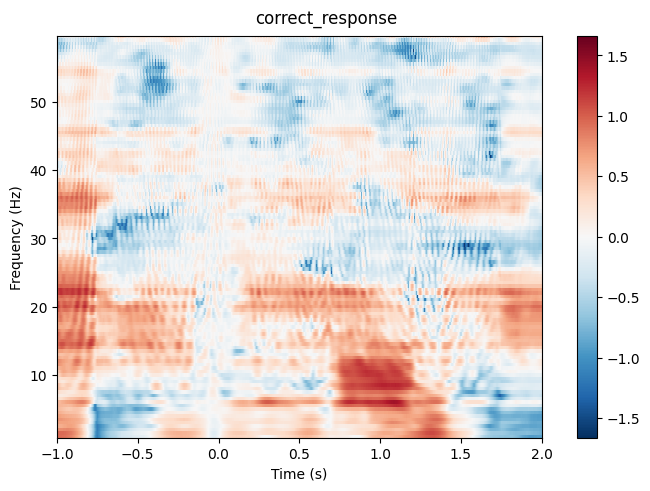

Applying baseline correction (mode: logratio)


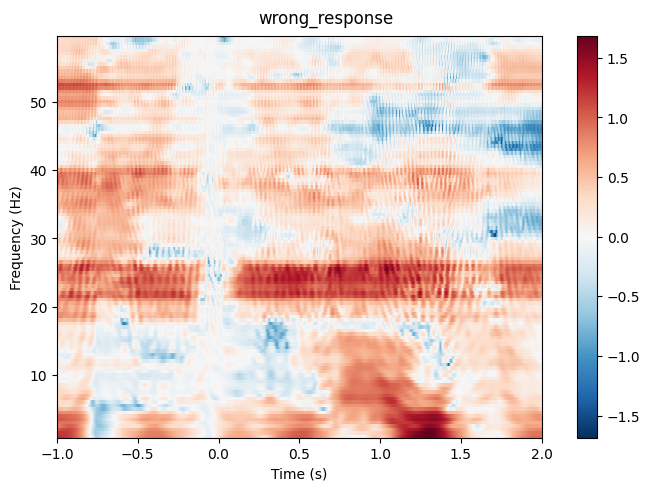

[<Figure size 640x480 with 2 Axes>]

In [9]:
# Plot time-frequency map for condition 1
CMAP_hot = 'seismic'
power_1.plot(picks=[pick_channel], baseline=BASE_line, mode='logratio', title=contrast_event_1 ) # , cmap=CMAP_hot
# Plot time-frequency map for condition 2
power_2.plot(picks=[pick_channel], baseline=BASE_line, mode='logratio', title=contrast_event_2 ) # , cmap=CMAP_hot


Applying baseline correction (mode: logratio)


/opt/conda/lib/python3.9/site-packages/mne/baseline.py:116: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


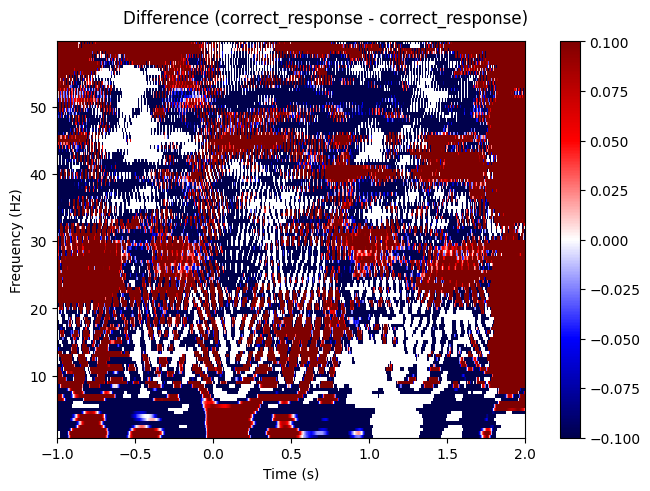

[<Figure size 640x480 with 2 Axes>]

In [10]:
CMAP_hot = 'seismic'
# Compute the difference between the two conditions
power_diff = power_1.copy()
power_diff.data -= power_2.data  # Subtract power of condition 2 from condition 1
# Plot the difference
power_diff.plot([3], baseline=(-0.1, 0), mode='logratio', title="Difference ("+contrast_event_1 +" - "+ contrast_event_1+")", cmap=CMAP_hot)

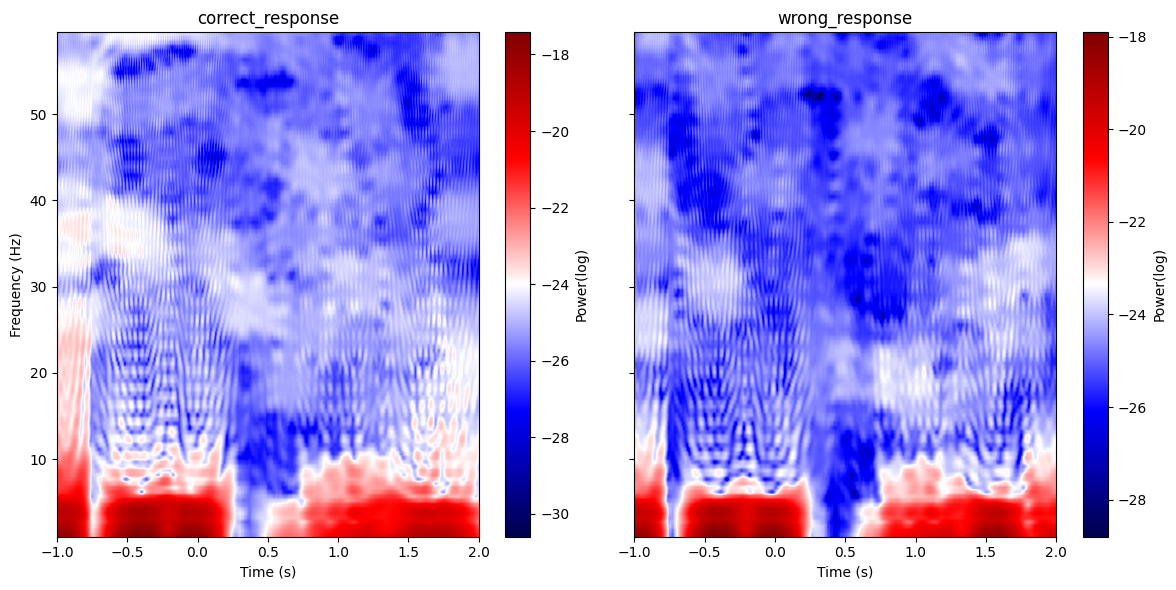

In [11]:
import matplotlib.pyplot as plt
import numpy as np

CMAP = sns.diverging_palette(230, 20, as_cmap=True)
chan_index = epochs.ch_names.index(pick_channel)

data_1 = power_1.data[chan_index]  # Average over channels
data_2 = power_2.data[chan_index]
freqs = power_1.freqs
times = power_1.times

# Create a figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot condition 1
im_1 = axes[0].imshow(
    np.log(data_1), aspect='auto', extent=[times[0], times[-1], freqs[0], freqs[-1]],
    origin='lower', cmap=CMAP_hot
)
axes[0].set_title(contrast_event_1)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (Hz)")
fig.colorbar(im_1, ax=axes[0], label="Power(log)")

# Plot condition 2
im_2 = axes[1].imshow(
    np.log(data_2), aspect='auto', extent=[times[0], times[-1], freqs[0], freqs[-1]],
    origin='lower', cmap=CMAP_hot
)
axes[1].set_title(contrast_event_2)
axes[1].set_xlabel("Time (s)")
fig.colorbar(im_2, ax=axes[1], label="Power(log)")

plt.tight_layout()
plt.show()

# Codes in test

In [8]:
# visualization inspection
#display(evoked_dict)
# Inspect the ERP for a specific event
#evoked = evoked_dict['vstim_on_after_correct']  # Replace with your event label
#print(evoked)
#evoked.plot()
# Compare ERP for multiple conditions
#mne.viz.plot_compare_evokeds(
#    {'Correct Response': evoked_dict['correct_response'], 
#     'Wrong Response': evoked_dict['wrong_response']},
#     ci=True, #ylim=dict(eeg=[-2, 2]),
#     show_sensors = True,
#     combine='median' # "median"
#)

{'feedback_on_after_no_response': <Evoked | 'feedback_on_after_no_response' (average, N=39), -1 – 2 s, baseline -0.1 – 0 s, 63 ch, ~1.5 MB>,
 'wrong_response': <Evoked | 'wrong_response' (average, N=30), -1 – 2 s, baseline -0.1 – 0 s, 63 ch, ~1.5 MB>,
 'correct_response': <Evoked | 'correct_response' (average, N=90), -1 – 2 s, baseline -0.1 – 0 s, 63 ch, ~1.5 MB>}

KeyError: 'vstim_on_after_correct'

In [46]:
from mne.stats import permutation_cluster_test

# Extract data for statistical testing
data_1 = power_1.data  # Shape: (n_channels, n_freqs, n_times)
data_2 = power_2.data

# Perform permutation cluster test
t_obs, clusters, cluster_pvals, _ = permutation_cluster_test([data_1, data_2], n_permutations=1000, tail=0, n_jobs=N_JOBS)

# Visualize significant clusters
print(f"Significant cluster p-values: {cluster_pvals}")

Using a threshold of 3.917550


/tmp/ipykernel_20754/944079633.py:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, cluster_pvals, _ = permutation_cluster_test([data_1, data_2], n_permutations=1000, tail=0, n_jobs=N_JOBS)


stat_fun(H1): min=2.539742809071748e-10 max=41.18270507869548
Running initial clustering …
Found 22 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Significant cluster p-values: [0.001 0.83  0.816 0.866 0.928 0.92  0.842 0.783 0.931 0.88  0.921 0.709
 0.892 0.846 0.864 0.768 0.895 0.922 0.913 0.88  0.92  0.928]


In [47]:
# Check for clusters
print(f"Number of clusters found: {len(clusters)}")
if len(clusters) == 0:
    print("No significant clusters were found.")
else:
    # Extract significant clusters
    significant_clusters = [clusters[idx] for idx, pval in enumerate(cluster_pvals) if pval < 0.05]
    print(f"Number of significant clusters: {len(significant_clusters)}")


Number of clusters found: 22
Number of significant clusters: 1


In [48]:
print(len(significant_clusters[0][0]))
print(len(significant_clusters[0][1]))

819021
819021


In [49]:
import numpy as np

original_shape = data_1.shape
# Extract significant clusters
significant_clusters = [clusters[idx] for idx, pval in enumerate(cluster_pvals) if pval < 0.05]

# Iterate through significant clusters
for cluster in significant_clusters:
    cluster_indices = np.where(cluster)  # Extract the flattened indices (1D)

    # Convert flattened indices back to 2D frequency-time indices
    freq_time_indices = np.unravel_index(cluster_indices[0], original_shape[1:])  # Exclude channels if present

    # Extract frequency and time ranges
    freq_indices = freq_time_indices[0]  # Frequency indices
    time_indices = freq_time_indices[1]  # Time indices

    # Frequency and time values
    freq_range = (freqs[freq_indices[0]], freqs[freq_indices[-1]])
    time_range = (power_1.times[time_indices[0]], power_1.times[time_indices[-1]])

    print(f"Significant frequency range: {freq_range[0]}–{freq_range[1]} Hz")
    print(f"Significant time range: {time_range[0]}–{time_range[1]} seconds")

Significant frequency range: 1.0–1.0 Hz
Significant time range: -1.0–-0.999 seconds


In [50]:
significant_clusters
print(f"Condition 1 data shape: {data_1.shape}")
print(f"Condition 2 data shape: {data_2.shape}")

Condition 1 data shape: (63, 390, 3001)
Condition 2 data shape: (63, 390, 3001)


In [51]:
# Extract significant clusters
significant_clusters = [clusters[idx] for idx, pval in enumerate(cluster_pvals) if pval < 0.05]

# Extract time and frequency ranges for significant clusters
for cluster in significant_clusters:
    cluster_indices = np.where(cluster)  # Indices of the cluster
    freq_idx, time_idx = cluster_indices[1], cluster_indices[2]  # Frequency and time indices
    print(f"Significant frequency range: {freqs[freq_idx[0]]}–{freqs[freq_idx[-1]]} Hz")
    print(f"Significant time range: {power_1.times[time_idx[0]]}–{power_1.times[time_idx[-1]]} seconds")

IndexError: tuple index out of range

Fitted sphere radius:         96.1 mm
Origin head coordinates:      1.7 -18.9 3.4 mm
Origin device coordinates:    1.7 -18.9 3.4 mm
Using matplotlib as 2D backend.


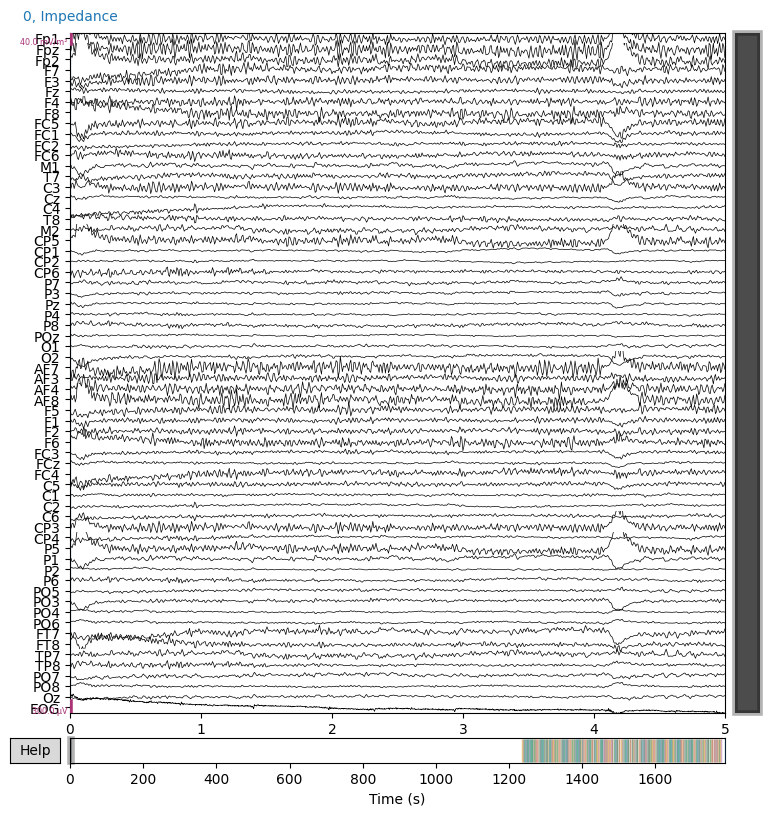

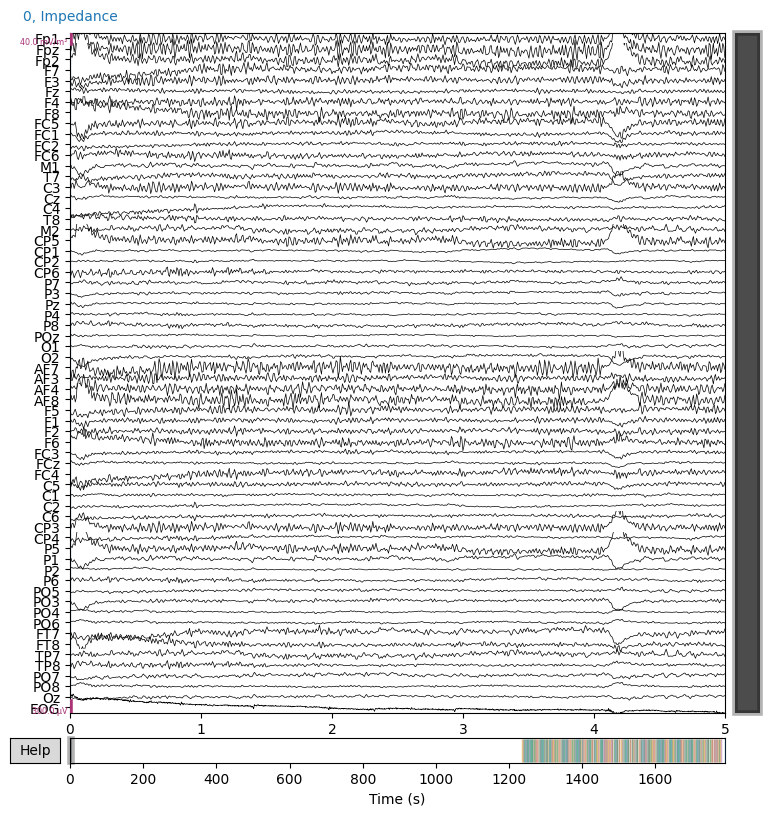

In [13]:
## CSD analysis
from mne.preprocessing import compute_current_source_density
# Convert raw EEG data to CSD
raw_csd = compute_current_source_density(subj_eeg)
# Plot the CSD-transformed EEG data
raw_csd.plot(duration=5, n_channels=64, title="EEG with CSD")
# Save the CSD-transformed data (optional)
#raw_csd.save('raw_csd.fif', overwrite=True)

In [59]:
from mne.time_frequency import tfr_morlet
# Define parameters for Morlet wavelets
N_JOBS = 8
freqs = np.arange(1, 40, 0.1)  # Frequencies from 1 to 40 Hz
n_cycles = freqs / 2         # Number of cycles per frequency
power_1 = tfr_morlet(condition_1, freqs=freqs, n_cycles=n_cycles, return_itc=False, n_jobs=N_JOBS)
power_2 = tfr_morlet(condition_2, freqs=freqs, n_cycles=n_cycles, return_itc=False, n_jobs=N_JOBS)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
inst is Evoked, setting `average=False`


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    6.2s finished


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
inst is Evoked, setting `average=False`


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    5.8s finished


2 duplicate electrode labels found:
M1/P1, M2/TP7
Plotting 61 unique labels.


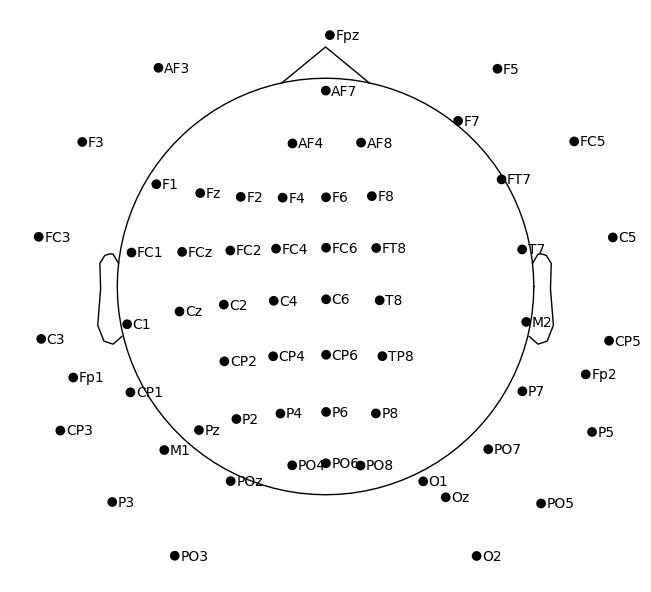

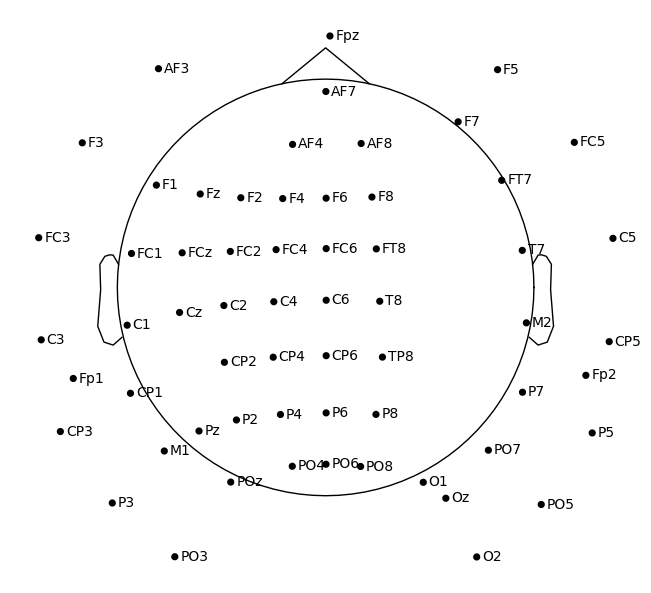

In [16]:
# Montage problem need to fix
# Extract the montage from the raw data
raw_montage = subj_eeg_cleaned.get_montage()
# Plot the montage of your EEG data
raw_montage.plot()

In [18]:
evoked_dict['vstim_on_after_correct'].plot_topomap(times=[0.1, 0.2, 0.3])

ValueError: The following electrodes have overlapping positions, which causes problems during visualization:
M1, M2, P1, TP7

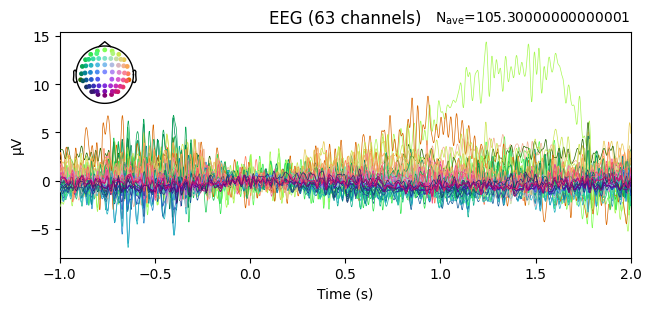

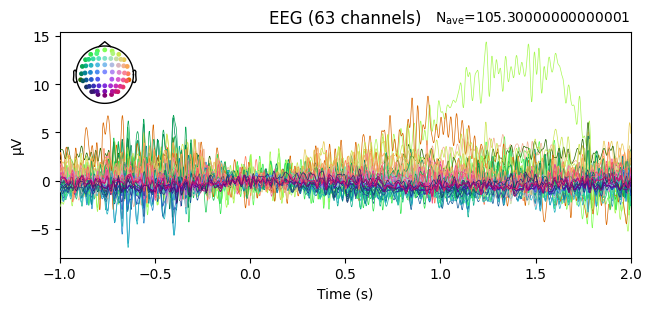

In [18]:
# Compute difference wave
evoked_diff = mne.combine_evoked(
    [evoked_dict['correct_response'], -evoked_dict['wrong_response']],
    weights='equal'
)

# Plot the difference wave
evoked_diff.plot()

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   21.3s


No baseline correction applied


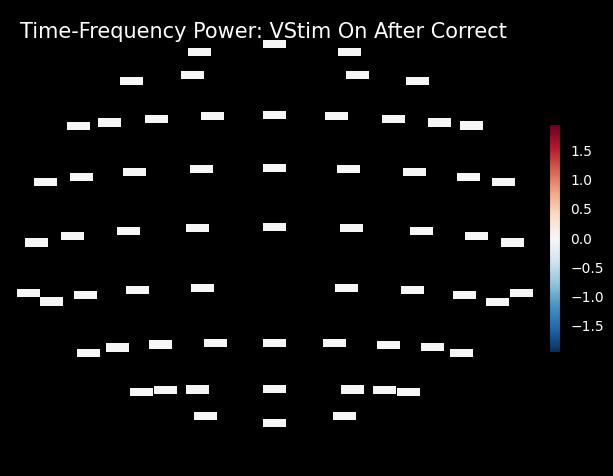

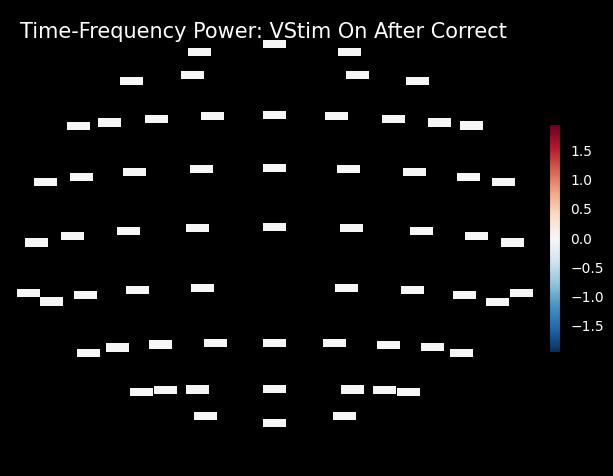

In [19]:
from mne.time_frequency import tfr_morlet

# Time-frequency decomposition for a specific event
freqs = np.arange(1, 40, 1)  # Frequencies from 1 to 40 Hz
n_cycles = freqs / 2         # Number of cycles per frequency

power = tfr_morlet(epochs['vstim_on_after_correct'], freqs=freqs, n_cycles=n_cycles, return_itc=False)

# Plot the time-frequency power
power.plot_topo(title="Time-Frequency Power: VStim On After Correct")

In [22]:
from mne.stats import permutation_cluster_test

# Extract data for two conditions
data_correct = epochs['correct_response'].get_data()
data_wrong = epochs['wrong_response'].get_data()

# Perform permutation t-test
t_obs, clusters, cluster_pv, _ = permutation_cluster_test(
    [data_correct, data_wrong], n_permutations=1000, tail=0)

# Visualize significant clusters
print(f"Cluster p-values: {cluster_pv}")

Using a threshold of 3.921478
stat_fun(H1): min=3.410865358290741e-08 max=15.702920830203126
Running initial clustering …
Found 504 clusters


/tmp/ipykernel_43191/3567612373.py:8: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, cluster_pv, _ = permutation_cluster_test(


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Cluster p-values: [1.    1.    1.    0.994 1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    0.999 1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.996 1.
 1.    1.    1.    1.    1.    1.    1.    1.    0.999 1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    0.892 1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    0.993 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    0.917 1.    1.    1.    1.    1.    1.    1.
 1

In [28]:
mne.__version__

'1.7.0'